In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline
import seaborn as sns

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score

Using TensorFlow backend.


In [2]:
from tf_unet import image_util
from tf_unet import unet
from tf_unet import util

In [3]:
output_path = "./trained_shallowNN_k1_epoch50_LR1_data_trainset_20190717"
prediction_path = "./prediction_shallowNN_k1_epoch50_LR1_data_trainset_20190717"

In [4]:
# prepare data

k = 1# choose convolutional filter size

training_data = image_util.ImageDataProvider("./data_trainset_20190717/*.tif")
i=26 #number of images
x_train, y_train = training_data(i)  #max=1, min=0
print(x_train.shape)
print(y_train.shape)

valid_data = image_util.ImageDataProvider("./data_tuneset_20190717/*.tif")
i=6 #number of images
x_valid, y_valid = valid_data(i)

test_data = image_util.ImageDataProvider("./data_testset_random_20190812/*.tif")
i=6 #number of images
x_test, y_test = test_data(i)

train_x = x_train
valid_x = x_valid
test_x = x_test

#make output the same as imput (test model's ability to learn identity function)
#y_train = x_train
#y_valid = x_valid
#y_test = x_test
#train_y = y_train[...,int(k/2):1000-int(k/2)+1,int(k/2):1000-int(k/2)+1,0]
#valid_y = y_valid[...,int(k/2):1000-int(k/2)+1,int(k/2):1000-int(k/2)+1,0]
#test_y = y_test[...,int(k/2):1000-int(k/2)+1,int(k/2):1000-int(k/2)+1,0]

#crop label shape to match model output for odd k
#train_y = y_train[...,int(k/2):1000-int(k/2)+1,int(k/2):1000-int(k/2)+1,1]
#valid_y = y_valid[...,int(k/2):1000-int(k/2)+1,int(k/2):1000-int(k/2)+1,1]
#test_y = y_test[...,int(k/2):1000-int(k/2)+1,int(k/2):1000-int(k/2)+1,1]
#crop label shape to match model output for even k
train_y = y_train[...,int(k/2):1000-int(k/2),int(k/2):1000-int(k/2),1]
valid_y = y_valid[...,int(k/2):1000-int(k/2),int(k/2):1000-int(k/2),1]
test_y = y_test[...,int(k/2):1000-int(k/2),int(k/2):1000-int(k/2),1]

#fix dimension
train_y= np.stack([train_y], axis = 3)
valid_y= np.stack([valid_y], axis = 3)
test_y= np.stack([test_y], axis = 3)

print(train_x.shape)
print(train_y.shape)
print(max(train_x.flatten()))
print(min(train_x.flatten()))
print(max(train_y.flatten()))
print(min(train_y.flatten()))

Number of files used: 26
Number of channels: 1
Number of classes: 2
(26, 1000, 1000, 1)
(26, 1000, 1000, 2)
Number of files used: 6
Number of channels: 1
Number of classes: 2
Number of files used: 6
Number of channels: 1
Number of classes: 2
(26, 1000, 1000, 1)
(26, 1000, 1000, 1)
1.0
0.0
1.0
0.0


In [5]:
batch_size = 1
epochs = 50

model = Sequential()
model.add(Conv2D(1, kernel_size = (k,k), data_format = 'channels_last',
                     input_shape = (1000,1000,1), kernel_initializer = 'random_uniform'))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1),
              metrics=['acc'])

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)#,
#                    validation_data=(valid_x, valid_y))


Instructions for updating:
Colocations handled automatically by placer.


2020-04-15 15:12:32,023 From /home/yao/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1000, 1000, 1)     2         
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 1000, 1)     0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


2020-04-15 15:12:32,093 From /home/yao/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/50
26/26 [==============================] - 1s 46ms/step - loss: 0.1579 - acc: 0.9936
Epoch 2/50
26/26 [==============================] - 1s 48ms/step - loss: 0.0545 - acc: 0.9936
Epoch 3/50
26/26 [==============================] - 1s 42ms/step - loss: 0.0457 - acc: 0.9936
Epoch 4/50
26/26 [==============================] - 1s 42ms/step - loss: 0.0424 - acc: 0.9936
Epoch 5/50
26/26 [==============================] - 1s 43ms/step - loss: 0.0407 - acc: 0.9936
Epoch 6/50
26/26 [==============================] - 1s 40ms/step - loss: 0.0396 - acc: 0.9936
Epoch 7/50
26/26 [==============================] - 1s 40ms/step - loss: 0.0387 - acc: 0.9936
Epoch 8/50
26/26 [==============================] - 1s 40ms/step - loss: 0.0379 - acc: 0.9936
Epoch 9/50
26/26 [==============================] - 1s 44ms/step - loss: 0.0373 - acc: 0.9936
Epoch 10/50
26/26 [==============================] - 1s 39ms/step - loss: 0.0367 - acc: 0.9936
Epoch 11/50
26/26 [==============================] - 1s 39m

Text(0.5, 1.0, 'Training and validation loss')

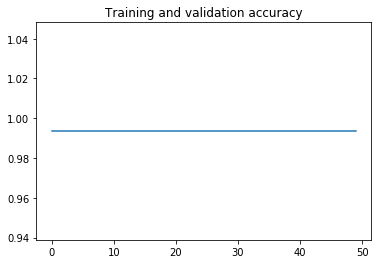

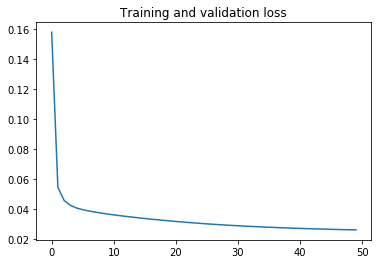

In [6]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
#val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.plot(range(len(acc)), acc)
#plt.plot(range(len(acc)), val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(range(len(loss)), loss)
#plt.plot(range(len(loss)), val_loss)
plt.title('Training and validation loss')

In [7]:
# prediction
prediction = model.predict(test_x)
prediction = np.array(prediction)

test_y_ = test_y.flatten()
test_y_predict = prediction.flatten()
print(max(test_y_predict))
print(min(test_y_predict))
print(max(test_y_))
print(min(test_y_))


0.09082851
0.0027082264
1.0
0.0


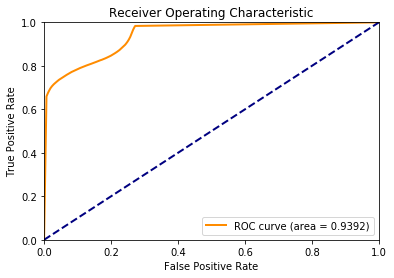

AUC =  0.939209482502288


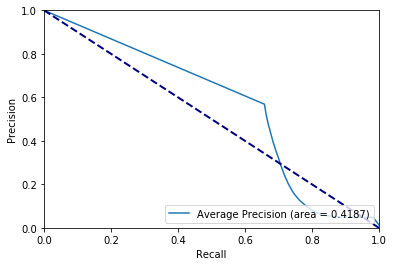

AP =  0.418678893382102


In [8]:
fpr, tpr, thresholds = roc_curve(test_y_,test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)

precision, recall, thresholds = precision_recall_curve(test_y_, test_y_predict)
AP = average_precision_score(test_y_, test_y_predict)
plt.figure()
plt.plot(recall, precision, label = 'Average Precision (area = %0.4f)' % AP)
plt.plot([0, 1], [1, 0], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'lower right')
plt.show()
print('AP = ',AP)

In [9]:
import scipy.io as sio
dict={
    "fprate":fpr, 
    "tprate":tpr,
    "recall":recall, 
    "precision":precision
}

sio.savemat('performance'+prediction_path[12:]+'.mat', dict)

In [10]:
## SAVE MODEL
import os

# detect the current working directory and print it
os.mkdir(output_path)
os.chdir(output_path)

# serialize model to JSON
model_json = model.to_json()
with open(output_path + "model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(output_path + "model.h5")
print("Saved model to disk")

os.chdir('/home/yao/Downloads/tf_unet-master/demo') # back to demo directory

Saved model to disk


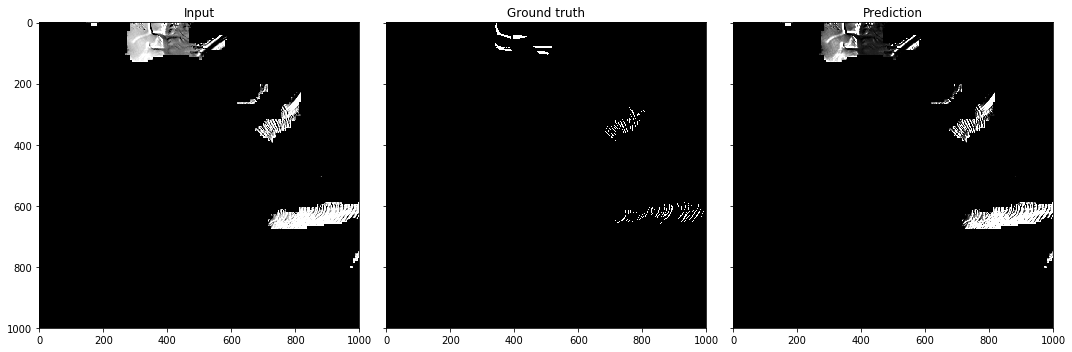

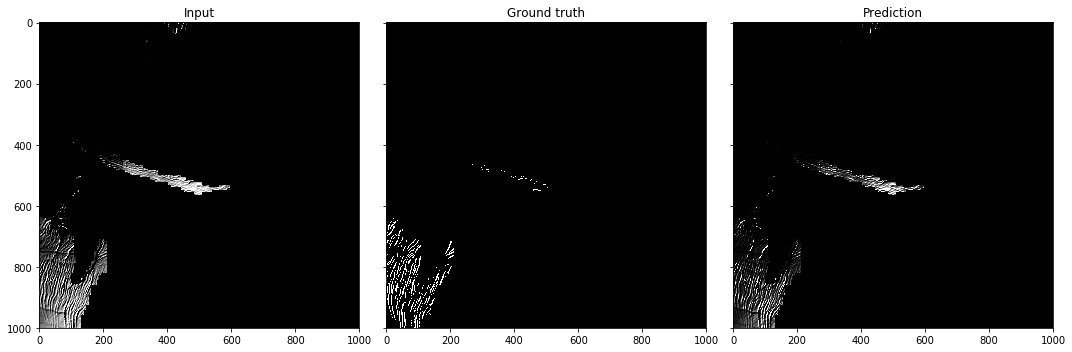

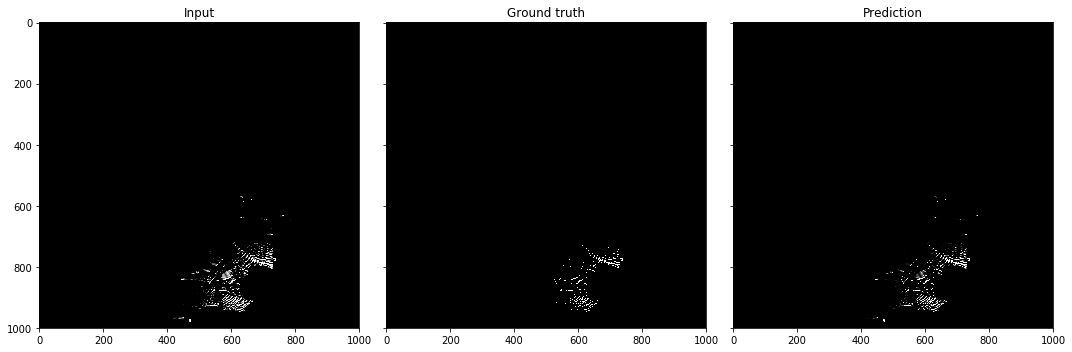

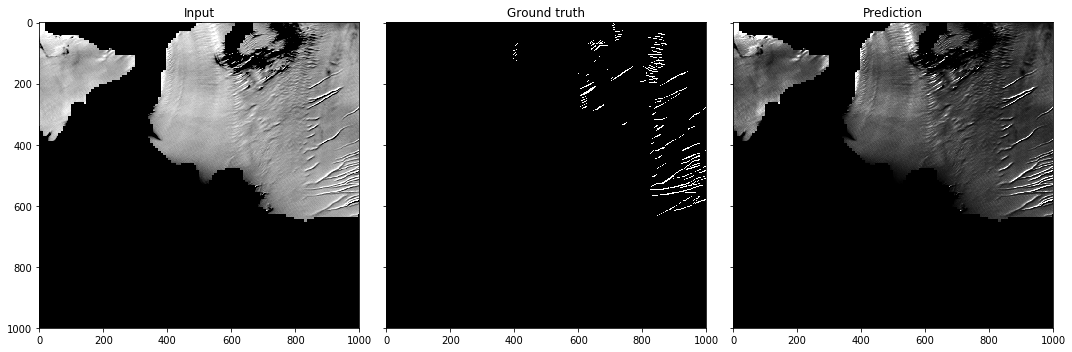

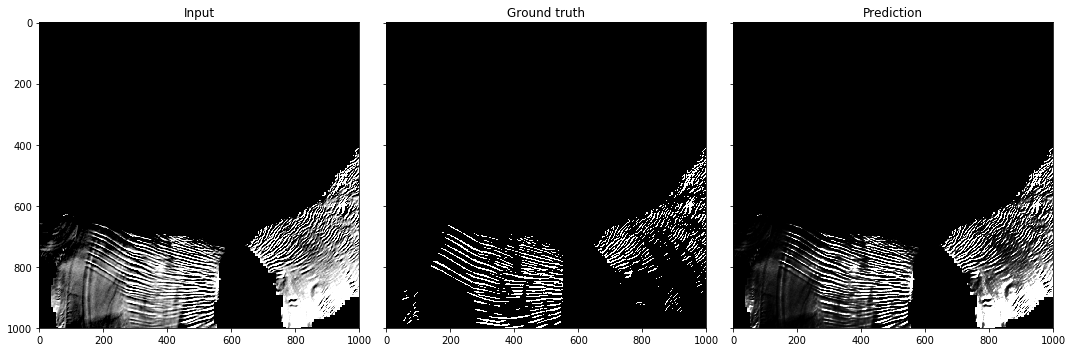

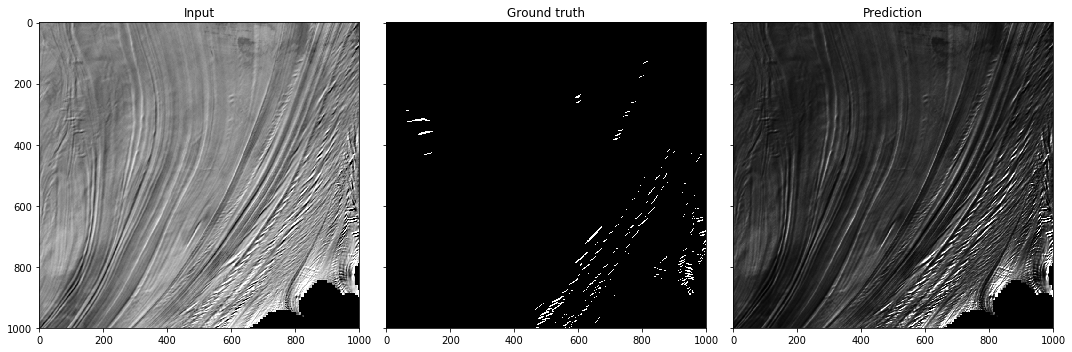

In [11]:
# display
for i in range(0,6):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    ax[0].imshow(test_x[i,...,0], aspect="auto")
    ax[1].imshow(test_y[i,...,0], aspect="auto")
    ax[2].imshow(prediction[i,...,0], aspect="auto")
    ax[0].set_title("Input")
    ax[1].set_title("Ground truth")
    ax[2].set_title("Prediction")
    fig.tight_layout()

## test on Roos ice shelf

In [12]:
#prepare test data
test_data = image_util.ImageDataProvider("./data_ross/*.tif")
i=2 #number of images
x_test, y_test = test_data(i)
print(x_test.shape)
print(y_test.shape)
test_x = x_test
test_y = y_test[...,int(k/2):1000-int(k/2)+1,int(k/2):1000-int(k/2)+1,1]
test_y= np.stack([test_y], axis = 3)

prediction = model.predict(test_x)
prediction = np.array(prediction)

Number of files used: 2
Number of channels: 1
Number of classes: 2
(2, 1000, 1000, 1)
(2, 1000, 1000, 2)


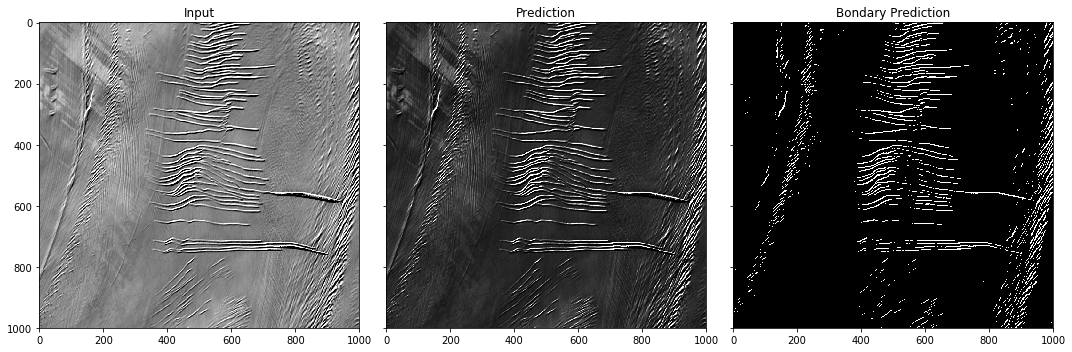

In [14]:
# display
i=1#sample index
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
ax[0].imshow(x_test[i,...,0], aspect="auto")
ax[1].imshow(prediction[i,...,0], aspect="auto")
mask = prediction[i,...,0] > 0.05
ax[2].imshow(mask, aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Prediction")
ax[2].set_title("Bondary Prediction")
fig.tight_layout()